In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf

import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.models import Model


2024-05-16 02:39:57.565838: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 02:39:58.576518: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 02:40:00.428916: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 02:40:10.267100: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

# Insert MLflow tracking setup here
import mlflow
import mlflow.keras

mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment('Lympho-Detection-Models-Experiments-New-2')

2024/05/14 20:11:20 INFO mlflow.tracking.fluent: Experiment with name 'Lympho-Detection-Models-Experiments-New-2' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/840071520885809475', creation_time=1715697680377, experiment_id='840071520885809475', last_update_time=1715697680377, lifecycle_stage='active', name='Lympho-Detection-Models-Experiments-New-2', tags={}>

In [3]:
files=[]
paths = []
for dirname, _, filenames in os.walk('Original/Pro'):
    for filename in filenames:
        path = os.path.join(dirname, filename)    
        paths.append(path)
        files.append(filename)

In [4]:
mpaths = []
for dirname, _, filenames in os.walk('Segmented/Pro'):
    for filename in filenames:
        path = os.path.join(dirname, filename)    
        mpaths.append(path)

In [5]:
df0=pd.DataFrame(columns=['file','path','mpath'])
df0['file']=sorted(files)
df0['path']=sorted(paths)
df0['mpath']=sorted(mpaths)
display(df0)
df=df0.iloc[0:len(df0)//2]
test_df=df0.iloc[len(df0)//2:]

,file,path,mpath
0,WBC-Malignant-Pro-001.jpg,Original/Pro/WBC-Malignant-Pro-001.jpg,Segmented/Pro/WBC-Malignant-Pro-001.jpg
1,WBC-Malignant-Pro-002.jpg,Original/Pro/WBC-Malignant-Pro-002.jpg,Segmented/Pro/WBC-Malignant-Pro-002.jpg
2,WBC-Malignant-Pro-003.jpg,Original/Pro/WBC-Malignant-Pro-003.jpg,Segmented/Pro/WBC-Malignant-Pro-003.jpg
3,WBC-Malignant-Pro-004.jpg,Original/Pro/WBC-Malignant-Pro-004.jpg,Segmented/Pro/WBC-Malignant-Pro-004.jpg
4,WBC-Malignant-Pro-005.jpg,Original/Pro/WBC-Malignant-Pro-005.jpg,Segmented/Pro/WBC-Malignant-Pro-005.jpg
...,...,...,...
799,WBC-Malignant-Pro-800.jpg,Original/Pro/WBC-Malignant-Pro-800.jpg,Segmented/Pro/WBC-Malignant-Pro-800.jpg
800,WBC-Malignant-Pro-801.jpg,Original/Pro/WBC-Malignant-Pro-801.jpg,Segmented/Pro/WBC-Malignant-Pro-801.jpg
801,WBC-Malignant-Pro-802.jpg,Original/Pro/WBC-Malignant-Pro-802.jpg,Segmented/Pro/WBC-Malignant-Pro-802.jpg
802,WBC-Malignant-Pro-803.jpg,Original/Pro/WBC-Malignant-Pro-803.jpg,Segmented/Pro/WBC-Malignant-Pro-803.jpg


In [6]:
img_size = [256,256]

def data_augmentation(car_img, mask_img):
    if tf.random.uniform(()) > 0.5:
        car_img = tf.image.flip_left_right(car_img)
        mask_img = tf.image.flip_left_right(mask_img)

    return car_img, mask_img

def preprocessing(car_path, mask_path):
    car_img = tf.io.read_file(car_path) 
    car_img = tf.image.decode_jpeg(car_img, channels=3)
    car_img = tf.image.resize(car_img, img_size)
    car_img = tf.cast(car_img, tf.float32) / 255.0
    
    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_jpeg(mask_img, channels=3)
    mask_img = tf.image.resize(mask_img, img_size)
    mask_img = mask_img[:,:,:1]    
    mask_img = tf.math.sign(mask_img)
    
    return car_img, mask_img

def create_dataset(df, train = False):
    if not train:
        ds = tf.data.Dataset.from_tensor_slices((df["path"].values, df["mpath"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((df["path"].values, df["mpath"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        ds = ds.map(data_augmentation, tf.data.AUTOTUNE)

    return ds

In [7]:
train_df, valid_df = train_test_split(df, random_state=42, test_size=.25)
train = create_dataset(train_df, train = True)
valid = create_dataset(valid_df)
test = create_dataset(test_df)

In [8]:
TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 16
BUFFER_SIZE = 1000

In [9]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE)
test_dataset = test.batch(BATCH_SIZE)

In [10]:
# Define a custom callback to print and log metrics during training
class PrintAndLogMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, model_name):
        super().__init__()
        self.model_name = model_name

    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            for metric, value in logs.items():
                print(f"{self.model_name} - Epoch {epoch + 1}: {metric} = {value}")
                mlflow.log_metric(f"{self.model_name}_{metric}", value, step=epoch)

In [11]:
# Define the U-Net model
def build_unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Downsampling through the model
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    bn = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)

    # Upsampling
    u1 = tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(bn)
    u1 = tf.keras.layers.concatenate([u1, c2])
    u2 = tf.keras.layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(u1)
    u2 = tf.keras.layers.concatenate([u2, c1])

    # Output layer
    outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='sigmoid')(u2)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


# Define different models here (Insert new model definitions or ensure they are defined before this block)
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Activation
from tensorflow.keras.models import Model

def build_simplified_cnn():
    inputs = Input(shape=(256, 256, 3))
    
    # Encoder
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Decoder to match the output size of 256x256
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(x)
    x = Activation('relu')(x)
    
    # Final output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

    model = Model(inputs, outputs)
    return model

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121

def build_densenet_based_model():
    base_model = DenseNet121(include_top=False, input_shape=(256, 256, 3), weights='imagenet')
    x = base_model.output

    # Adding upsampling layers
    x = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # size becomes 16x16
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # size becomes 32x32
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # size becomes 64x64
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # size becomes 128x128
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # size becomes 256x256

    # Final output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)  # Ensure single channel output

    model = Model(inputs=base_model.input, outputs=outputs)
    return model


In [12]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

In [13]:
def visualize(display_list):
    plt.figure(figsize=(12,12))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
    visualize([sample_image, sample_mask, pred_mask])

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:
            show_predictions(sample_image, sample_mask)

EPOCHS = 30
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [15]:
# Calculate the number of training examples
TRAIN_LENGTH = len(train_df)  # Ensure you have defined train_df correctly
BATCH_SIZE = 16  # or whatever batch size you are using

# Calculate steps per epoch
steps_per_epoch = TRAIN_LENGTH // BATCH_SIZE

# Calculate the number of validation examples
VALIDATION_LENGTH = len(valid_df)  # Ensure you have defined valid_df correctly

# Calculate validation steps
validation_steps = VALIDATION_LENGTH // BATCH_SIZE


In [1]:
import sys
sys.path.append('../')

In [3]:
from utils.model_definition import build_densenet_based_model

2024-05-16 03:06:33.204877: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 03:06:33.208527: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 03:06:33.258223: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 03:06:39.146595: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
def log_metrics(history, metrics):
    for epoch in range(len(history.history['loss'])):
        mlflow.log_metric("train_loss", history.history['loss'][epoch], step=epoch)
        mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)
        for metric in metrics:
            mlflow.log_metric(f"train_{metric}", history.history[metric][epoch], step=epoch)
            mlflow.log_metric(f"val_{metric}", history.history[f"val_{metric}"][epoch], step=epoch)

# MLflow tracking for experiments with different model architectures
print('1')
with mlflow.start_run(run_name='ALL Image Classification Experiments'):
    print('2')

    # Nested run for the U-Net model
    with mlflow.start_run(nested=True, run_name='U-Net Model'):
        print('3')
        unet_model = build_unet_model(1)
        print('4')
        unet_model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coef, 'binary_accuracy'])
        print('5')
        history = unet_model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch,
                       validation_data=valid_dataset, validation_steps=validation_steps,
                       callbacks=[early_stop])
        print('6')
        mlflow.log_param("model_type", "U-Net")
        mlflow.log_param("optimizer", "adam")
        mlflow.log_param("loss_function", "dice_loss")
        mlflow.log_param("metrics", ["dice_coef", "binary_accuracy"])
        log_metrics(history, ["dice_coef", "binary_accuracy"])
        
        # Evaluate on the test set
        test_loss, test_dice_coef, test_binary_accuracy = unet_model.evaluate(test_dataset)
        mlflow.log_metric("test_loss", test_loss)
        mlflow.log_metric("test_dice_coef", test_dice_coef)
        mlflow.log_metric("test_binary_accuracy", test_binary_accuracy)
        
        mlflow.keras.log_model(unet_model, 'unet_model')
        print('7')

    # Nested run for the Simplified CNN model
    with mlflow.start_run(nested=True, run_name='Simplified CNN Model'):
        print('8')
        cnn_model = build_simplified_cnn()
        print('9')
        cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        print('10')
        history = cnn_model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch,
                      validation_data=valid_dataset, validation_steps=validation_steps)
        print('11')
        mlflow.log_param("model_type", "Simplified CNN")
        mlflow.log_param("optimizer", "adam")
        mlflow.log_param("loss_function", "binary_crossentropy")
        mlflow.log_param("metrics", ["accuracy"])
        log_metrics(history, ["accuracy"])
        
        # Evaluate on the test set
        test_loss, test_accuracy = cnn_model.evaluate(test_dataset)
        mlflow.log_metric("test_loss", test_loss)
        mlflow.log_metric("test_accuracy", test_accuracy)
        
        mlflow.keras.log_model(cnn_model, 'simplified_cnn_model')
        print('12')

    # Nested run for the DenseNet-based model
    with mlflow.start_run(nested=True, run_name='DenseNet-based Model'):
        print('13')
        densenet_model = build_densenet_based_model()
        print('14')
        densenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        print('15')
        history = densenet_model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=steps_per_epoch,
                           validation_data=valid_dataset, validation_steps=validation_steps)
        print('16')
        mlflow.log_param("model_type", "DenseNet-based")
        mlflow.log_param("optimizer", "adam")
        mlflow.log_param("loss_function", "binary_crossentropy")
        mlflow.log_param("metrics", ["accuracy"])
        log_metrics(history, ["accuracy"])
        
        # Evaluate on the test set
        test_loss, test_accuracy = densenet_model.evaluate(test_dataset)
        mlflow.log_metric("test_loss", test_loss)
        mlflow.log_metric("test_accuracy", test_accuracy)
        
        mlflow.keras.log_model(densenet_model, 'densenet_based_model')
        print('17')

1
2
3
4
5
Epoch 1/30
18/18 [==============================] - 2s 69ms/step - loss: 0.7983 - dice_coef: 0.2017 - binary_accuracy: 0.3344 - val_loss: 0.7792 - val_dice_coef: 0.2208 - val_binary_accuracy: 0.1301
Epoch 2/30
18/18 [==============================] - 1s 63ms/step - loss: 0.7795 - dice_coef: 0.2206 - binary_accuracy: 0.1285 - val_loss: 0.7787 - val_dice_coef: 0.2213 - val_binary_accuracy: 0.1301
Epoch 3/30
18/18 [==============================] - 1s 58ms/step - loss: 0.7864 - dice_coef: 0.2135 - binary_accuracy: 0.1239 - val_loss: 0.7787 - val_dice_coef: 0.2213 - val_binary_accuracy: 0.1301
Epoch 4/30
18/18 [==============================] - 1s 59ms/step - loss: 0.7828 - dice_coef: 0.2176 - binary_accuracy: 0.1263 - val_loss: 0.7787 - val_dice_coef: 0.2213 - val_binary_accuracy: 0.1301
Epoch 5/30
18/18 [==============================] - 1s 58ms/step - loss: 0.7789 - dice_coef: 0.2213 - binary_accuracy: 0.1289 - val_loss: 0.7787 - val_dice_coef: 0.2213 - val_binary_accuracy: 0.

2024/05/14 20:11:30 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/tv/vdhp2vmj6ng60qz9m2cglgsh0000gn/T/tmproc8ezet/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/tv/vdhp2vmj6ng60qz9m2cglgsh0000gn/T/tmproc8ezet/model/data/model/assets
2024/05/14 20:11:35 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/tv/vdhp2vmj6ng60qz9m2cglgsh0000gn/T/tmproc8ezet/model, flavor: tensorflow). Fall back to return ['tensorflow==2.15.0', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 


7
8
9
10
Epoch 1/30


/Users/vishalvignesh/miniforge3/envs/tensorflow/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


18/18 [==============================] - 2s 84ms/step - loss: 0.4933 - accuracy: 0.8561 - val_loss: 0.3843 - val_accuracy: 0.8699
Epoch 2/30
18/18 [==============================] - 1s 76ms/step - loss: 0.3769 - accuracy: 0.8741 - val_loss: 0.3791 - val_accuracy: 0.8699
Epoch 3/30
18/18 [==============================] - 1s 77ms/step - loss: 0.3737 - accuracy: 0.8714 - val_loss: 0.3777 - val_accuracy: 0.8699
Epoch 4/30
18/18 [==============================] - 1s 77ms/step - loss: 0.3689 - accuracy: 0.8732 - val_loss: 0.3727 - val_accuracy: 0.8699
Epoch 5/30
18/18 [==============================] - 1s 79ms/step - loss: 0.3658 - accuracy: 0.8721 - val_loss: 0.3795 - val_accuracy: 0.8699
Epoch 6/30
18/18 [==============================] - 1s 76ms/step - loss: 0.3566 - accuracy: 0.8756 - val_loss: 0.3682 - val_accuracy: 0.8699
Epoch 7/30
18/18 [==============================] - 1s 76ms/step - loss: 0.3590 - accuracy: 0.8703 - val_loss: 0.3473 - val_accuracy: 0.8699
Epoch 8/30
18/18 [======

2024/05/14 20:12:19 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/tv/vdhp2vmj6ng60qz9m2cglgsh0000gn/T/tmpbqc8uiwb/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/tv/vdhp2vmj6ng60qz9m2cglgsh0000gn/T/tmpbqc8uiwb/model/data/model/assets


12
13
14
15
Epoch 1/30
18/18 [==============================] - 21s 443ms/step - loss: 0.3935 - accuracy: 0.8550 - val_loss: 1.0211 - val_accuracy: 0.8699
Epoch 2/30
18/18 [==============================] - 12s 329ms/step - loss: 0.2830 - accuracy: 0.8730 - val_loss: 0.4496 - val_accuracy: 0.8699
Epoch 3/30
18/18 [==============================] - 6s 353ms/step - loss: 0.2688 - accuracy: 0.8704 - val_loss: 0.6295 - val_accuracy: 0.8699
Epoch 4/30
18/18 [==============================] - 6s 333ms/step - loss: 0.2471 - accuracy: 0.8761 - val_loss: 0.6027 - val_accuracy: 0.8699
Epoch 5/30
18/18 [==============================] - 6s 320ms/step - loss: 0.2449 - accuracy: 0.8723 - val_loss: 0.4694 - val_accuracy: 0.8699
Epoch 6/30
18/18 [==============================] - 6s 320ms/step - loss: 0.2257 - accuracy: 0.8724 - val_loss: 0.7696 - val_accuracy: 0.8699
Epoch 7/30
18/18 [==============================] - 6s 317ms/step - loss: 0.2123 - accuracy: 0.8808 - val_loss: 0.6694 - val_accuracy:

2024/05/14 20:15:41 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/tv/vdhp2vmj6ng60qz9m2cglgsh0000gn/T/tmpgomcdl5r/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/tv/vdhp2vmj6ng60qz9m2cglgsh0000gn/T/tmpgomcdl5r/model/data/model/assets


17


1/1 [==============================] - 2s 2s/step


ValueError: num must be an integer with 1 <= num <= 15, not 16

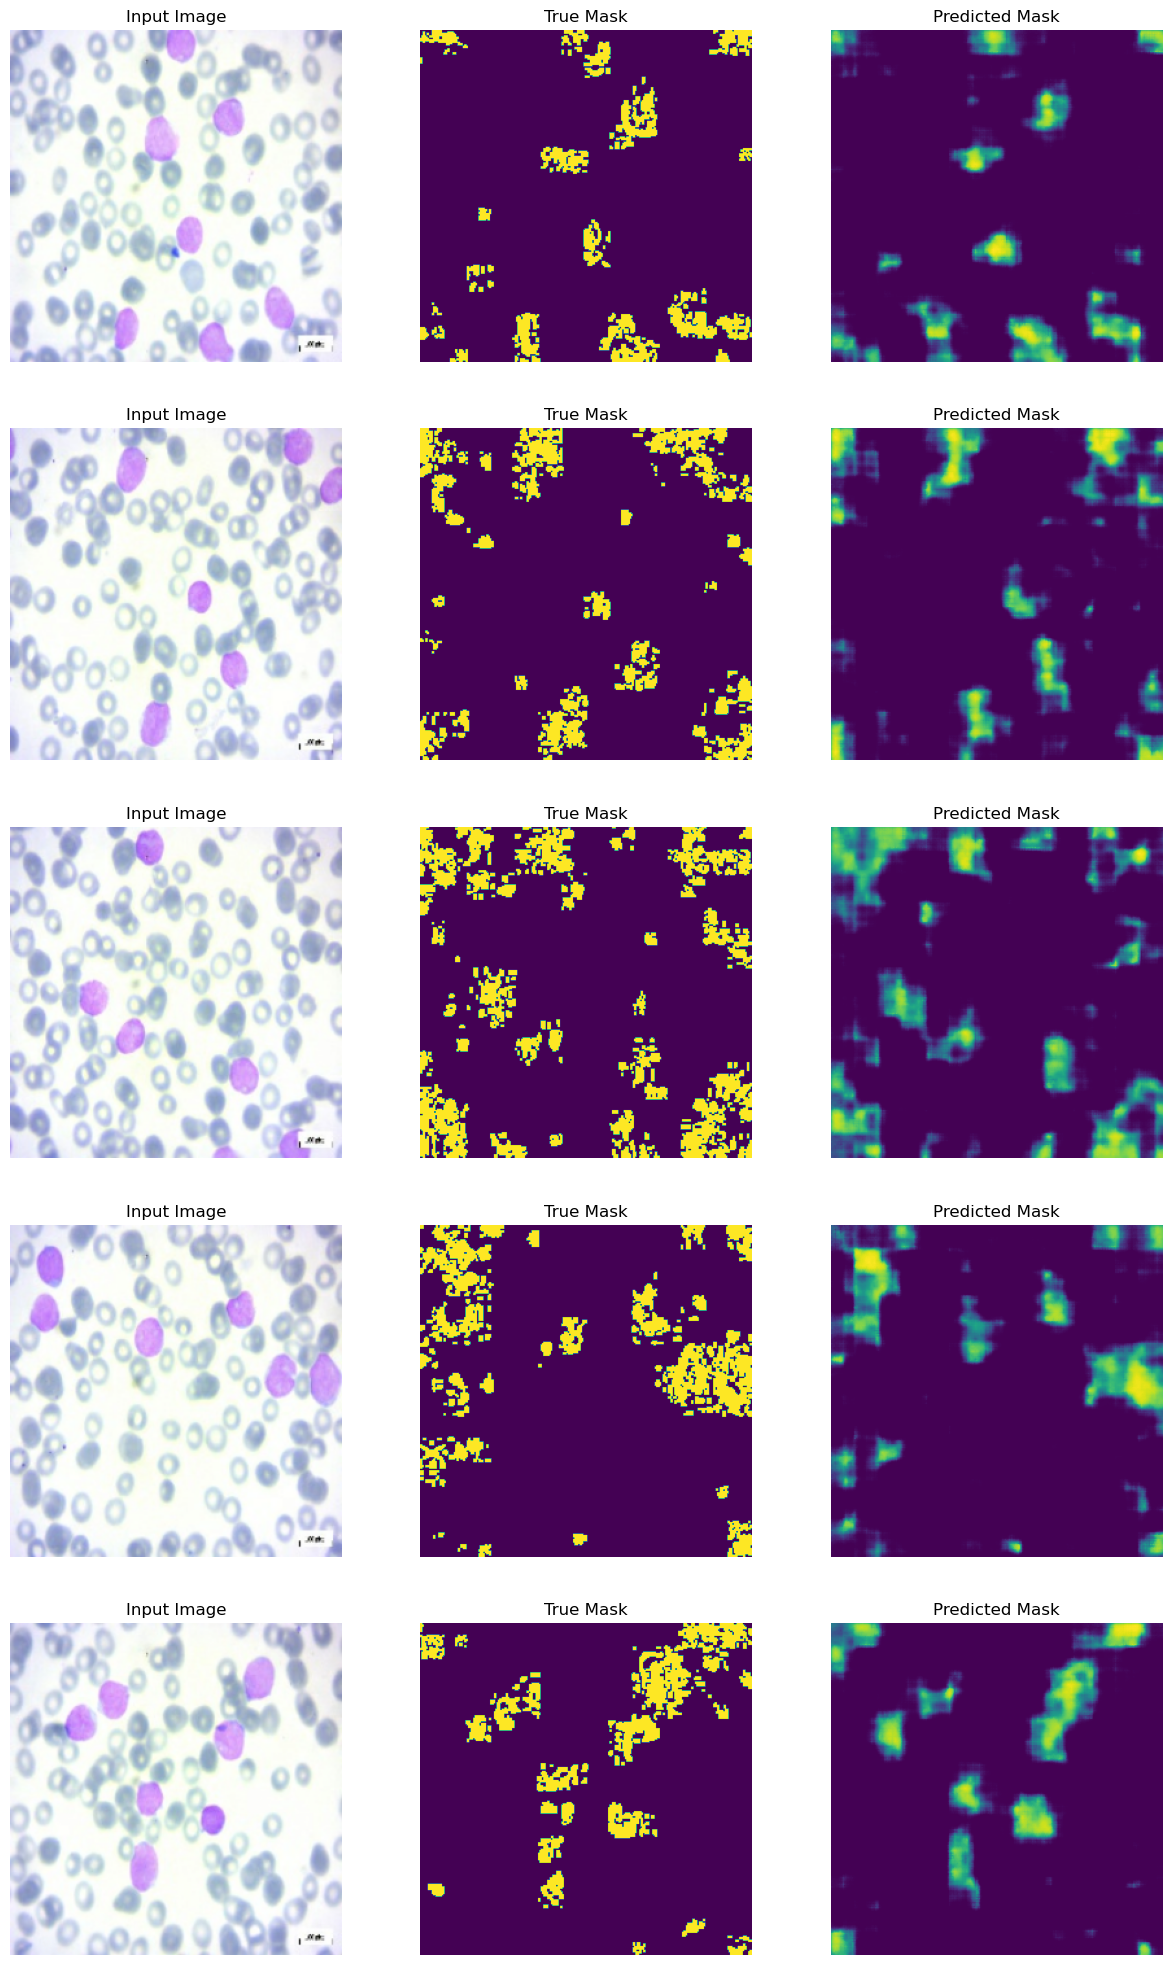

In [17]:
import matplotlib.pyplot as plt

def display_sample_predictions(model, dataset, num_samples=5):
    plt.figure(figsize=(15, 5 * num_samples))
    
    # Loop over images and masks directly taken from the dataset
    for i, (images, masks) in enumerate(dataset.take(num_samples)):
        # Predict the mask directly using batched images
        pred_masks = model.predict(images)
        
        for j in range(len(images)):
            plt.subplot(num_samples, 3, 3 * i + 1)
            plt.title("Input Image")
            plt.imshow(tf.keras.preprocessing.image.array_to_img(images[j]))
            plt.axis("off")

            plt.subplot(num_samples, 3, 3 * i + 2)
            plt.title("True Mask")
            plt.imshow(tf.keras.preprocessing.image.array_to_img(masks[j]))
            plt.axis("off")

            plt.subplot(num_samples, 3, 3 * i + 3)
            plt.title("Predicted Mask")
            plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_masks[j]))
            plt.axis("off")

            # Increment i to move to the next set of subplots
            i += 1
    
    plt.tight_layout()
    plt.show()

# Example usage with your model and dataset
display_sample_predictions(densenet_model, test_dataset, num_samples=5)


In [18]:
# Save the DenseNet model weights
densenet_model.save_weights('densenet_weights.h5')